In [1]:
# Imports
import sys
import networkx as nx # type: ignore
import graphviz
import pandas as pd
import numpy as np # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import CausalModel
import dowhy.datasets

sys.path.append('../')
from src.data.make_dataset import load_data, merge_all_datasets
from src.data.preprocess import preprocessing

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.neighbors import NearestNeighbors # type: ignore

import warnings
warnings.filterwarnings("ignore")

/Users/annanatasha/Documents/DSO 585 Consulting/causal-attribution-analysis/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/processed/data.csv")
df.shape

In [3]:
nodes_list = [
'Rating',
'Product_category_encoded',
'freight_value',
'distance_km',
'season',
'is_delivery_late'
]

df[nodes_list].isnull().sum()

Rating                       997
Product_category_encoded       0
freight_value                833
distance_km                 1414
season                         0
is_delivery_late               0
dtype: int64

In [4]:
# Temporary fix for imputing rating
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

## Finding the optimal lag

Lags are crucial in time-series and temporal data analysis because they allow us to account for delayed effects. In this case, a delay in delivery might not immediately impact the payment value but could affect future transactions (e.g., customer dissatisfaction resulting in lower payment values for future purchases). By introducing lags, we can model the temporal relationship between variables like delivery delay (is_delivery_late) and payment value (payment_value) to see how past events (lagged values) influence future outcomes.

The code below is broken down into several steps:
1. Create lagged variables (in this project, a total of 10 lagged columns)
2. Evaluate lagged features using cross-validation: evaluates different lag lengths using cross-validation to see which lag performs the best in predicting payment value
3. Modelling with Random Forest Regressor: 
4. Training and Testing: the random forest regressor is trained on the training data, and predictions are made for both the training and test sets. 
5. Evaluate different lags: calculates the MSE for each lag.

We evaluate different lags from 1 to 10 days and calculate the MSE for each lag. The best lag is the one with the lowest MSE, and would tell us the optimal number of days to lag the variables for the most accurate predictions.

In [7]:
df = df.dropna()

In [ ]:
#Imports
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

**Create lagged variables**

In [9]:
# Function to create lagged variables of 'is_delivery_late' and 'Rating'
def create_lags_by_group(df, group_by, lag_features, max_lag):
    for feature in lag_features:
        for lag in range(1, max_lag + 1):
            # Shift the feature values that is grouped by each customer
            df[f'{feature}_lag{lag}'] = df.groupby(group_by)[feature].shift(lag)
    return df

# Function to evaluate different lag lengths using cross validation to see which lag peforms the best in predicting payment value
def evaluate_lags(df, group_by, lag_range, lag_features, outcome_var):
    results = []  # This will store the (lag, mse_score) pairs
    
    # Ensure the lag features and outcome_var exist in df dataframe
    missing_cols = [col for col in lag_features + [outcome_var] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Columns missing from dataframe: {missing_cols}")
    
    for max_lag in lag_range:
        # Create lagged variables up to the current max_lag using the create_lags_by_group function
        df_lagged = df.copy()
        df_lagged = create_lags_by_group(df_lagged, group_by, lag_features, max_lag)

        # Drop missing values (due to lag creation)
        df_lagged = df_lagged.dropna(subset=lag_features + [outcome_var])

        # Prepare features (X) and target (y)
        X = df_lagged.drop(columns=[outcome_var])  # Independent variables
        y = df_lagged[outcome_var]  # Dependent variable (outcome)

        # Ensure features are numeric
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize a Random Forest Regressor model
        model = RandomForestRegressor(random_state=42, n_estimators=100)

        # Fit the model
        model.fit(X_train, y_train)

        # Calculate training and testing Mean Squared Error (MSE)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        # Compare MSE to see if overfitting occurs
        if train_mse > test_mse:
            print(f"Warning: Overfitting for lag {max_lag}. Train MSE is higher than Test MSE.")

        # Store the result as a tuple (max_lag, test_mse)
        results.append((max_lag, test_mse))

    return results

# Define features and target
lag_features = ['is_delivery_late', 'Rating']  # Features you want to lag
outcome_var = 'payment_value'  # Target variable

# Define the group to lag within product_id
group_by = 'customer_id'

# Define the range of lags to evaluate
lag_range = range(1, 6)  # Test from 1 lag to 10 lags

# Call the function and evaluate lag ranges
results = evaluate_lags(df, group_by, lag_range, lag_features, outcome_var)

# Print results for different lag ranges
for lag, score in results:
    print(f"Lag {lag}: Avg Mean Squared Error (MSE) = {score}")

# Choose the best lag based on the score (lower MSE is better)
optimal_lag = min(results, key=lambda x: x[1])[0]
print(f"Optimal number of lags: {optimal_lag}")

Lag 1: Avg Mean Squared Error (MSE) = 11308.410472072732
Lag 2: Avg Mean Squared Error (MSE) = 12406.658127937202
Lag 3: Avg Mean Squared Error (MSE) = 12726.665434529967
Lag 4: Avg Mean Squared Error (MSE) = 12334.68495769885
Lag 5: Avg Mean Squared Error (MSE) = 12598.254001201876
Lag 6: Avg Mean Squared Error (MSE) = 12618.65248182162
Lag 7: Avg Mean Squared Error (MSE) = 12737.78613064981
Lag 8: Avg Mean Squared Error (MSE) = 12914.137552794093
Lag 9: Avg Mean Squared Error (MSE) = 12849.829873034867
Lag 10: Avg Mean Squared Error (MSE) = 12901.774174800164
Optimal number of lags: 1


**Results without incorporating Lag**

In [9]:
# Define covariates, treatment, and outcome
covariates = ['Product_category_encoded', 'season', 'Product_size', 'freight_value', 'distance_km']
treatment = 'is_delivery_late'
outcome = 'payment_value'

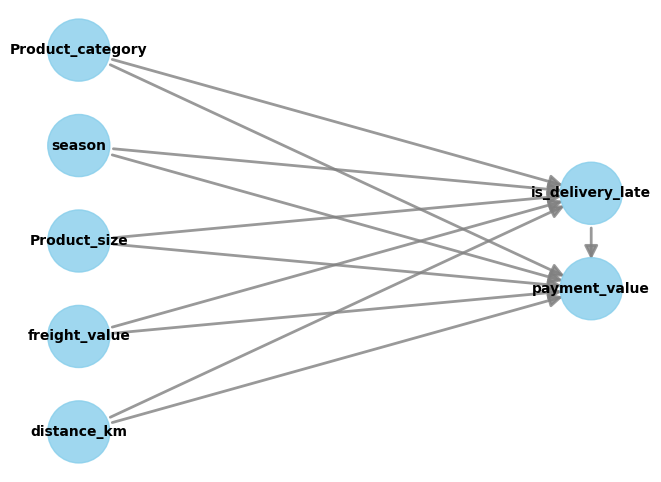

In [10]:
# Build the causal model
# We specify the treatment, outcome, and confounders in the model.
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=covariates
)

# View the graphical model
# This visualizes the causal structure and how variables are related.
model.view_model()

In [11]:
# Identify the causal effect
# Specify how to estimate the causal effect. Here we use matching with propensity scores.
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[payment_value|Product_category,season,distance_km,Produc ↪
d[is_delivery_late]                                                            ↪

↪                       
↪ t_size,freight_value])
↪                       
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→payment_value then P(payment_value|is_delivery_late,Product_category,season,distance_km,Product_size,freight_value,U) = P(payment_value|is_delivery_late,Product_category,season,distance_km,Product_size,freight_value)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [12]:
# Estimate the treatment effect using propensity score matching
# This will estimate the causal effect using Propensity Score Matching (PSM).
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

/Users/annanatasha/Documents/DSO 585 Consulting/causal-attribution-analysis/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/annanatasha/Documents/DSO 585 Consulting/causal-attribution-analysis/venv/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_estimator.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [13]:
# View the results
# This will show the average treatment effect (ATE) of late deliveries on review scores.
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[payment_value|Product_category,season,distance_km,Produc ↪
d[is_delivery_late]                                                            ↪

↪                       
↪ t_size,freight_value])
↪                       
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→payment_value then P(payment_value|is_delivery_late,Product_category,season,distance_km,Product_size,freight_value,U) = P(payment_value|is_delivery_late,Product_category,season,distance_km,Product_size,freight_value)

## Realized estimand
b: payment_value~is_delivery_late+Product_category+season+distance_km+Product_size+freight_value
Target units: ate

## Estimate
Mean value: -10.176221482518052



In [14]:
# Display the causal estimate, confidence intervals, and standard error
print("Causal Estimate (ATE):", estimate.value)

Causal Estimate (ATE): -10.176221482518052


In [15]:
print("Confidence Interval:", estimate.get_confidence_intervals())

Confidence Interval: (np.float64(-16.84191724389688), np.float64(-6.0311225350033375))


In [17]:
print("Standard Error:", estimate.get_standard_error())

Standard Error: 2.7692659611835273


/Users/annanatasha/Documents/DSO 585 Consulting/causal-attribution-analysis/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/annanatasha/Documents/DSO 585 Consulting/causal-attribution-analysis/venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/annanatasha/Documents/DSO 585 Consulting/causal-attribution-analysis/venv/lib/python3.9/site-packages/dowhy/causal_refuters/add_unobserved_common_cause.py:304: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a f

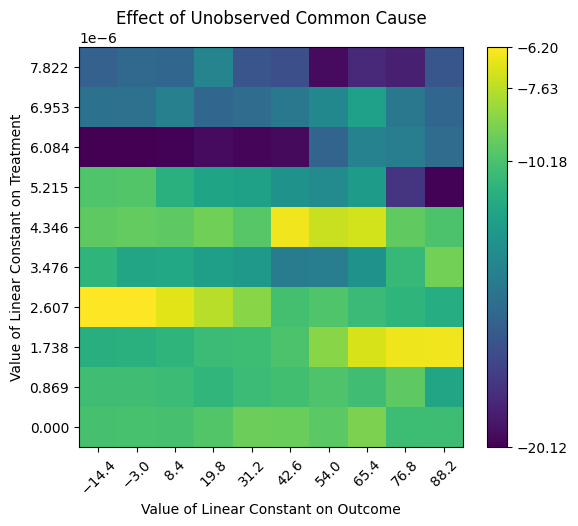

Refute: Add an Unobserved Common Cause
Estimated effect:-10.176221482518052
New effect:(np.float64(-20.11857897001342), np.float64(-6.201252120252087))



In [18]:
# Add an unobserved confounder and see how the treatment effect changes
refutation_unobserved_confounding = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause"
)

# Display the refutation results
print(refutation_unobserved_confounding)

In [19]:
# Estimate ATT using DoWhy
estimate_ATT = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att"  # Specify that we are interested in the ATT (treated units)
)

# Display the ATT
print("ATT (Average Treatment effect on the Treated):", estimate_ATT.value)

ATT (Average Treatment effect on the Treated): 6.455278433550879


In [20]:
# Estimate ATC using DoWhy
estimate_ATC = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="atc"  # Specify that we are interested in the ATC (control units)
    #ATC is where is_delivery_late = 0, so what would the outcome have been for those who didn't experience a delayed delivery, if they had
)

# Display the ATC
print("ATC (Average Treatment effect on the Controls):", estimate_ATC.value)

ATC (Average Treatment effect on the Controls): -11.286581494530035


**One-day lag incorporated**

In [27]:
# Define covariates, treatment, and outcome
covariates = ['Product_category', 'season', 'Product_size', 'freight_value', 'distance_km']
treatment = 'is_delivery_late_lag4'  # Define treatment as the 4-day lag version
outcome = 'payment_value'

In [36]:
# Check the unique values of the treatment variable
print(df['is_delivery_late_lag4'].value_counts())

is_delivery_late_lag4
0.0    118283
Name: count, dtype: int64


In [28]:
# Step 2: Drop rows with missing values due to lagging
df = df.dropna(subset=[treatment, outcome])  # Ensure no NaNs after lag creation

In [30]:
# Build the causal model using the lagged treatment
model = CausalModel(
    data=df,
    treatment=treatment,  # Use lagged treatment
    outcome=outcome,
    common_causes=covariates
)

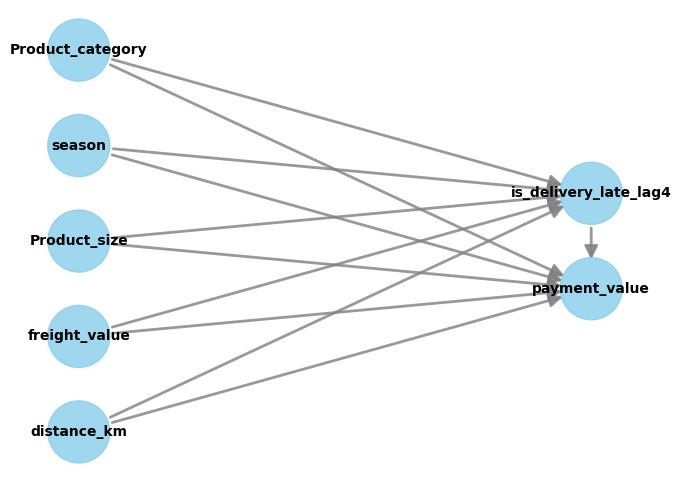

In [31]:
# View the graphical model (optional)
model.view_model()

In [32]:
# Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                   ↪
────────────────────────(E[payment_value|Product_category,season,distance_km,f ↪
d[is_delivery_late_lag4]                                                       ↪

↪                            
↪ reight_value,Product_size])
↪                            
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late_lag4} and U→payment_value then P(payment_value|is_delivery_late_lag4,Product_category,season,distance_km,freight_value,Product_size,U) = P(payment_value|is_delivery_late_lag4,Product_category,season,distance_km,freight_value,Product_size)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [35]:
# Estimate the treatment effect using propensity score matching
# This will estimate the causal effect using Propensity Score Matching (PSM).
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.float64(0.0)

In [33]:
print("ATE (Average Treatment Effect):", estimate.value)

NameError: name 'estimate' is not defined

## Mediation Analysis using DoWhy

In [38]:
# Add mediator to the model
model = CausalModel(
    data= df_clean,
    treatment='is_delivery_late',
    outcome='payment_value',
    common_causes= ['Product_category', 'season', 'Product_size', 'freight_value', 'distance_km', 'Rating'],
)

# Identify the frontdoor effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[payment_value|Product_category,season,distance_km,Produc ↪
d[is_delivery_late]                                                            ↪

↪                              
↪ t_size,Rating,freight_value])
↪                              
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→payment_value then P(payment_value|is_delivery_late,Product_category,season,distance_km,Product_size,Rating,freight_value,U) = P(payment_value|is_delivery_late,Product_category,season,distance_km,Product_size,Rating,freight_value)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [39]:
# Estimate the effect using frontdoor linear regression (for mediation)
frontdoor_estimate = model.estimate_effect(
    identified_estimand,
    method_name="frontdoor.linear_regression"
)
print("Frontdoor Estimate:", frontdoor_estimate)

Frontdoor Estimate: Estimation failed! No relevant identified estimand available for this estimation method.
